# Part2. 머신러닝, 딥러닝
### 시계열 모델을 통한 농수산물 소매가격 예측
1. 데이터 탐색
2. ARIMA
3. SARIMA
4. ARMA
5. LSTM

# 1. 데이터 탐색

In [1]:
## 필요 라이브러리
# 데이터 전처리 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib.pylab as plt
plt.rcParams['font.family'] = ('AppleGothic', 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns

# 통계 라이브러리
import pmdarima as pm

# 기타
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2017~2021년 데이터 불러오기
df = pd.read_csv('data/2017_2021_data.csv', usecols=[1,2,3], encoding='euc-kr')
df['날짜'] = pd.to_datetime(df['날짜'], infer_datetime_format = True)
df = df.set_index(['날짜'])
df.head()

,고구마가격,오이가격
날짜,,
2017-01-02,4442,8907.0
2017-01-03,4463,9011.0
2017-01-04,4461,9101.0
2017-01-05,4430,10296.0
2017-01-06,4423,10374.0


# 3. ARIMA
## 3.1 ARIMA 모델 차수 선택
- ARIMA Model Selection w/ Auto-ARIMA

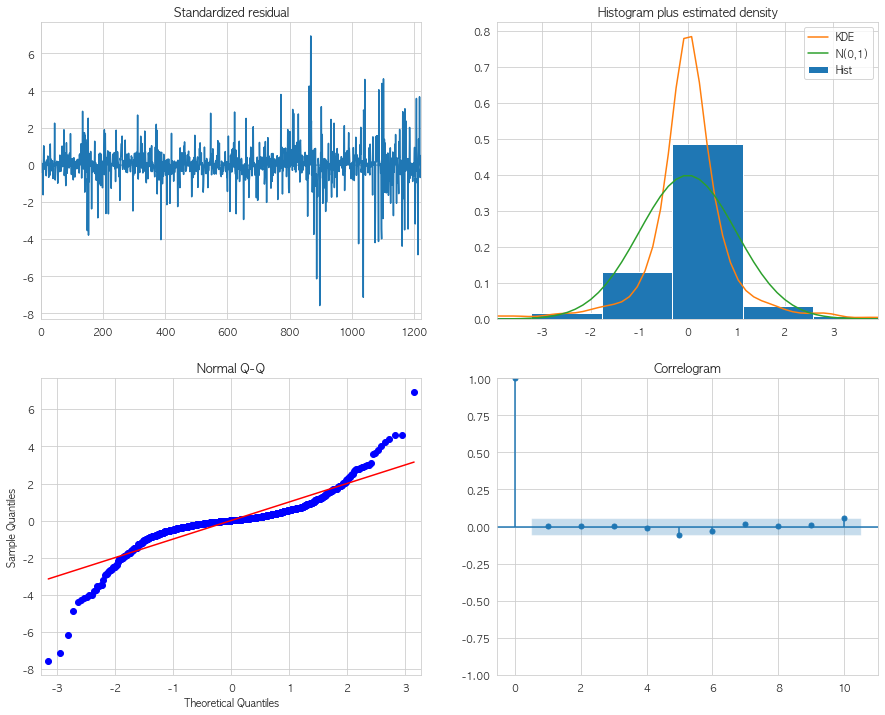

In [3]:
ARIMA_model_sp = pm.auto_arima(df['고구마가격'],
                            start_p=1,
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)


# 고구마 모델 진단
ARIMA_model_sp.plot_diagnostics(figsize=(15,12))
plt.savefig('data/arima01.png')
plt.show()

- Standardized residual : 원시 잔차를 잔차의 표준 편차 추정치로 나눈 값
    - 잔차가 표준 편차 단위로 얼마나 큰지를 정량화하므로 특이치를 식별하는 데 쉽게 사용할 수 있다.
    - 표준화 잔차가 3보다 큰(절대값) 관측치는 일부 관측치에 의해 특이치로 간주된다.

- Normal Q-Q
    - Theoretical Quantiles 와 Empirical Quantiles 를 Plotting한 것
    - => 결과) 정규분포 만족하지 않는다.

- Correlogram
    - ACF plot으로 자기자신과, 자기자신의 이전 autocorrelation(시계열이 과거 값과 얼마나 상관되어 있는지)을 나타낸다.

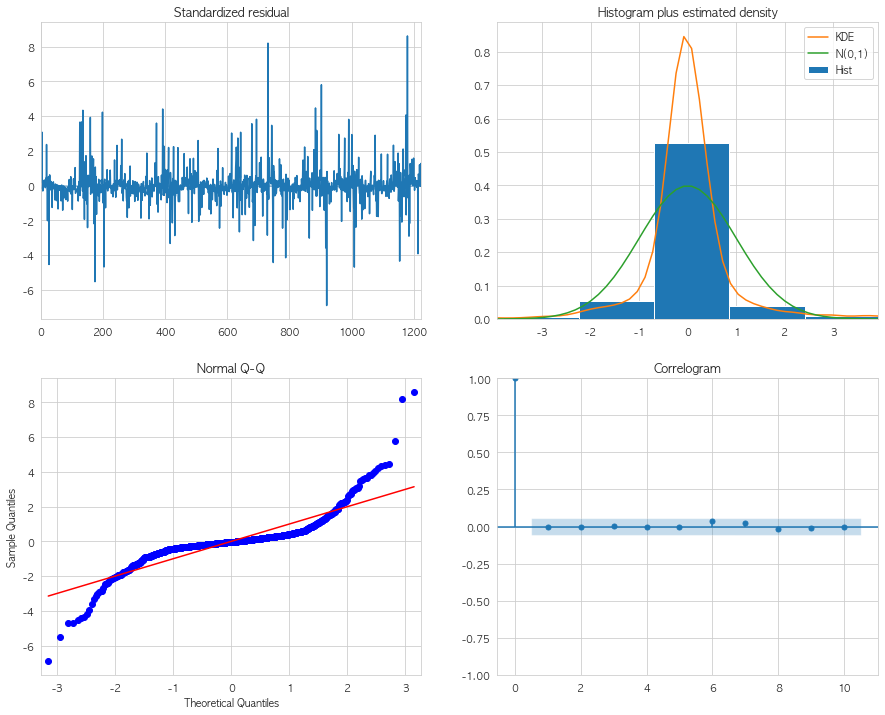

In [4]:
# 오이 모델 차수 선택
ARIMA_model_ccb = pm.auto_arima(df['오이가격'],
                            start_p=1,
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

# 오이 모델 진단
ARIMA_model_ccb.plot_diagnostics(figsize=(15,12))
plt.savefig('data/arima02.png')
plt.show()

## 3.2 ARIMA 모델 예측
##### 3.2.1 예측 함수 정의

In [5]:
## 예측 함수 정의
def forecast(ARIMA_model, df, df_actual, color, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True) #신뢰구간 출력
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,3))
    plt.plot(df, color=color)
    plt.plot(fitted_series, color='#FA5858')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=0.2)
    plt.plot(df_actual, color=color)
    plt.title("ARIMA/SARIMA - Forecast of Price")
    plt.savefig(f'data/arima{color}.png')
    plt.show()

##### 3.2.2 예측 평가를 위한 2022 데이터 불러오기

In [6]:
# 2022년 actual 데이터 불러오기
df_2022 = pd.read_csv('data/2022_data.csv', usecols=[1,2,3], encoding='euc-kr')
df_2022['날짜'] = pd.to_datetime(df_2022['날짜'], infer_datetime_format = True)
df_2022 = df_2022.set_index(['날짜'])
df_2022_sp = df_2022['고구마가격']
df_2022_ccb = df_2022['오이가격']

##### 3.2.3 ARIMA 모델을 이용한 가격 예측

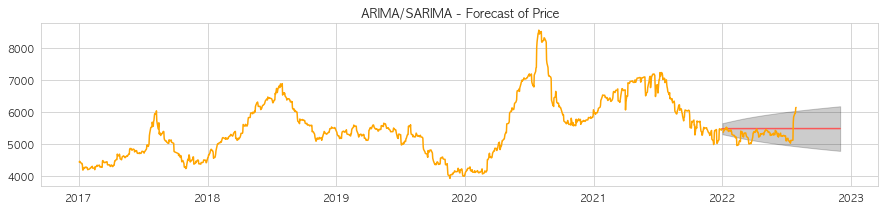

In [7]:
# 고구마 가격 예측
forecast(ARIMA_model_sp, df['고구마가격'], df_2022_sp, 'orange')

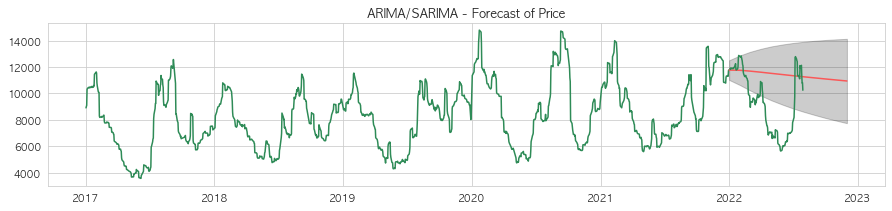

In [8]:
# 오이 가격 예측
forecast(ARIMA_model_ccb, df['오이가격'], df_2022_ccb, 'seagreen')

# 4. SARIMA
## 4.1 SARIMA 모델 선택 및 예측

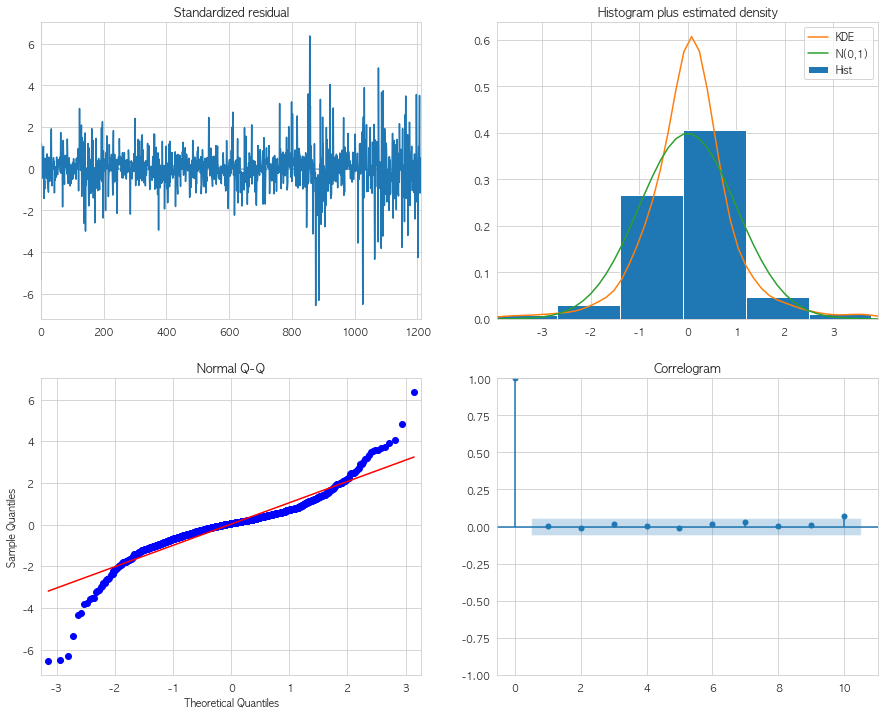

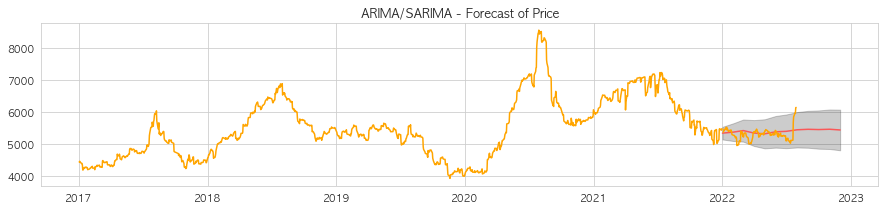

In [9]:
## 모델 차수 선택
# 고구마
SARIMA_model_sp = pm.auto_arima(df['고구마가격'], start_p=1, start_q=1,
                                test='adf',
                                max_p=3, max_q=3,
                                m=12, #12 is the frequncy of the cycle
                                start_P=0,
                                seasonal=True, #set to seasonal
                                d=None,
                                D=1, #order of the seasonal differencing
                                trace=False,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

# 모델 진단
SARIMA_model_sp.plot_diagnostics(figsize=(15,12))
plt.show()

# 예측
forecast(SARIMA_model_sp, df['고구마가격'], df_2022_sp, 'orange')

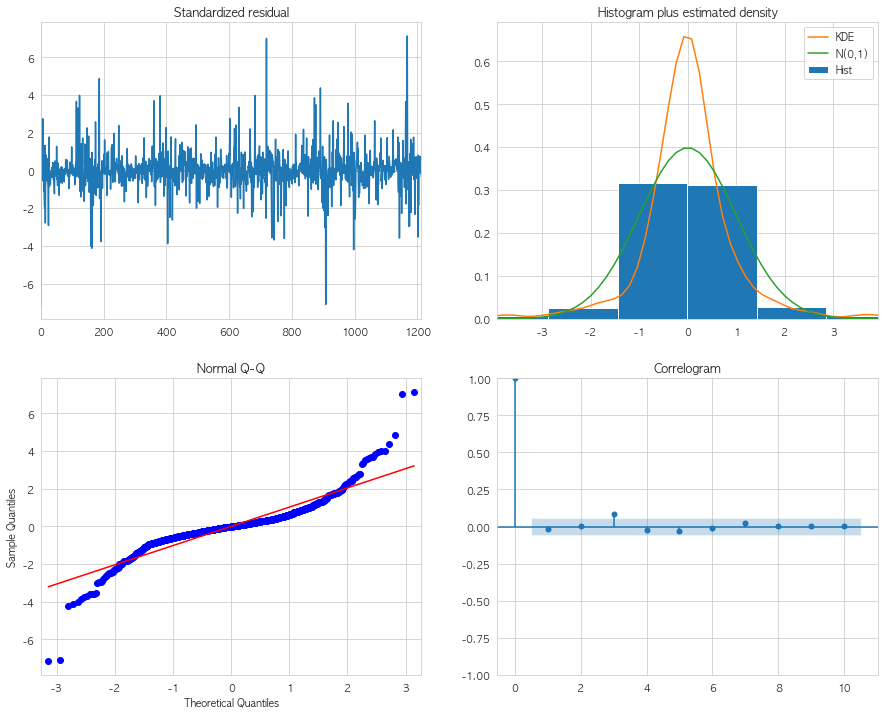

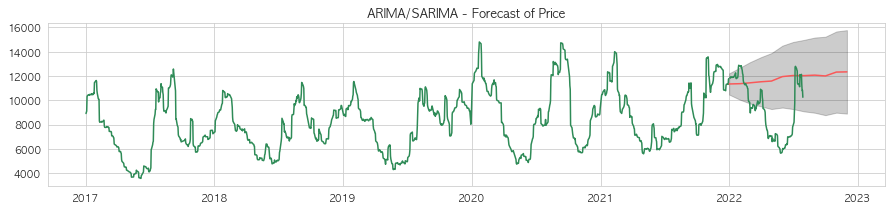

In [10]:
## 모델 차수 선택
# 오이
SARIMA_model_ccb = pm.auto_arima(df['오이가격'], start_p=1, start_q=1,
                                 test='adf',
                                 max_p=3, max_q=3,
                                 m=12, #12 is the frequncy of the cycle
                                 start_P=0,
                                 seasonal=True, #set to seasonal
                                 d=None,
                                 D=1, #order of the seasonal differencing
                                 trace=False,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

# 모델 진단
SARIMA_model_ccb.plot_diagnostics(figsize=(15,12))
plt.show()

# 예측
forecast(SARIMA_model_ccb, df['오이가격'], df_2022_ccb, 'seagreen')